In [1]:
# Plotting and Data Manipulation
import pandas as pd
import numpy as np
import math

import matplotlib.patches as mpatches

# Statistics and Machine Learning
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
import seaborn as sns

import scipy
from scipy.signal import savgol_filter

# Other
import importlib
import warnings
warnings.filterwarnings('ignore')


In [2]:
from pathlib import Path
import sys
parent_dir = str(Path().absolute().parent)
sys.path.append(parent_dir)

print(parent_dir)

d:\riset-fttm\patrick\Basic-WellLog-Interpretation


# **1. Data Preparation**

In [3]:
from src.data_prep.read_las import read_las

file_name = "../data/raw/llb-13_wire_lima (1).las"
well_name = "LL-4"
renamed_columns = {'DEPTH' : 'DEPT', 'RT' : 'DR', 'ILM' : 'MR', 'LLS':'SR', 'NPHI_CORR':'NPHI'} # {nama_asli : nama_baru, ... , dst}
columns = ["DEPT","GR", "CALI", "MR", "DR", "SR", "NPHI", "RHOB", "DT", "SP", "VSH", "RW", "WELL"]

data = read_las(file_name, well_name, renamed_columns, columns, keep_original = False)

Only engine='normal' can read wrapped files


In [4]:
data.head()

,WELL,DEPT,GR,CALI,DR,SR,RHOB,VSH,RW
0,LL-4,0.00,NaN,NaN,NaN,NaN,NaN,NaN,0.208680
1,LL-4,0.25,NaN,NaN,NaN,NaN,NaN,NaN,0.208663
2,LL-4,0.50,NaN,NaN,NaN,NaN,NaN,NaN,0.208646
3,LL-4,0.75,NaN,NaN,NaN,NaN,NaN,NaN,0.208629
4,LL-4,1.00,NaN,NaN,NaN,NaN,NaN,NaN,0.208612


# **2. Data Distribution Plot**

In [5]:
columns_to_plot = ["GR", "DR", "SR",  "RHOB", "VSH", "RW"]
columns_unit = ["API", "ohm/m", "ohm.m", "g/cm³", "v/v", "ohm"]

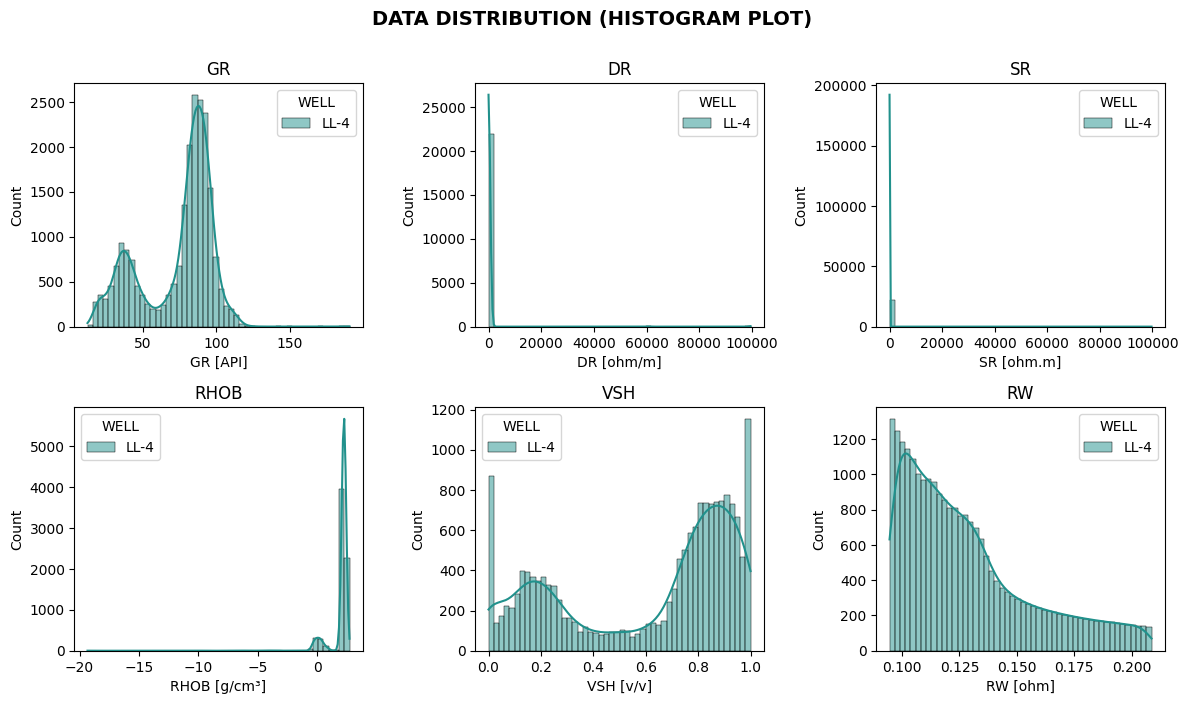

In [6]:
from src.data_vis.distPlot import boxplot, histplot, densityplot

histplot(data, columns_to_plot, columns_unit)

In [7]:
data.describe()

,DEPT,GR,CALI,DR,SR,RHOB,VSH,RW
count,24221.000000,21999.000000,7060.000000,21983.000000,21983.000000,7059.000000,17069.000000,24221.000000
mean,3027.500000,73.856982,8.860806,266.488130,5.742551,1.966650,0.612841,0.128514
std,1748.036193,24.475909,0.271770,4866.733836,672.211164,1.050185,0.333593,0.028291
min,0.000000,12.410000,8.340000,0.073000,0.061000,-19.330000,0.000000,0.094576
25%,1513.750000,52.580000,8.670000,0.822000,0.821000,2.190000,0.250700,0.106162
50%,3027.500000,83.390000,8.860000,1.191000,1.037000,2.260000,0.764900,0.121081
75%,4541.250000,91.070000,8.980000,1.648000,1.310000,2.300000,0.887600,0.142287
max,6055.000000,190.500000,11.040000,99434.687500,99667.593800,2.730000,1.000000,0.208680


# **4. Data Selection and Calculations**

In [8]:
data.head()

,WELL,DEPT,GR,CALI,DR,SR,RHOB,VSH,RW
0,LL-4,0.00,NaN,NaN,NaN,NaN,NaN,NaN,0.208680
1,LL-4,0.25,NaN,NaN,NaN,NaN,NaN,NaN,0.208663
2,LL-4,0.50,NaN,NaN,NaN,NaN,NaN,NaN,0.208646
3,LL-4,0.75,NaN,NaN,NaN,NaN,NaN,NaN,0.208629
4,LL-4,1.00,NaN,NaN,NaN,NaN,NaN,NaN,0.208612


In [9]:
# Create a copy of the data for selected well (Whicher-2)
selected_data = data[data['WELL'] == well_name].copy()

selected_data.describe()

,DEPT,GR,CALI,DR,SR,RHOB,VSH,RW
count,24221.000000,21999.000000,7060.000000,21983.000000,21983.000000,7059.000000,17069.000000,24221.000000
mean,3027.500000,73.856982,8.860806,266.488130,5.742551,1.966650,0.612841,0.128514
std,1748.036193,24.475909,0.271770,4866.733836,672.211164,1.050185,0.333593,0.028291
min,0.000000,12.410000,8.340000,0.073000,0.061000,-19.330000,0.000000,0.094576
25%,1513.750000,52.580000,8.670000,0.822000,0.821000,2.190000,0.250700,0.106162
50%,3027.500000,83.390000,8.860000,1.191000,1.037000,2.260000,0.764900,0.121081
75%,4541.250000,91.070000,8.980000,1.648000,1.310000,2.300000,0.887600,0.142287
max,6055.000000,190.500000,11.040000,99434.687500,99667.593800,2.730000,1.000000,0.208680


## *4.1 Input Core Data (Porosity and Permeability) for Selected WELL*

In [10]:
selected_data["core_por"] = ""
selected_data["core_perm"] = ""

# Define the number of random samples you want
num_samples = 100  # You can change this to the desired number of samples

# Generate random values for 'DEPT' between 900 and 4300
dept_values = np.random.uniform(0, 8400, num_samples)

# Generate random values for 'core_por' between 0 and 1 and "core_perm" between 0 and 1000
core_por_values = np.random.uniform(0, 1, num_samples)
core_perm_values = np.random.uniform(0, 1000, num_samples)

# Create a dictionary with the generated values. This for example only
dict_core = {
    'DEPT': dept_values.tolist(),  # Convert to a list
    'core_por': core_por_values.tolist(),  # Convert to a list
    "core_perm" : core_perm_values.tolist() # Convert to a list
}

# must inpute manually based on core data
"""dict_core = {'DEPT':[4220,4240,4260],
        'DEPT':[4220,4240,4260],
        'core_por':[0.148, 0.287,0.103],
        'core_perm':[0.0001,0.0001,0.0001]
       } """


core_selected_data = pd.DataFrame(dict_core)
selected_data.set_index("DEPT");

## *4.2 Data Visualizations*

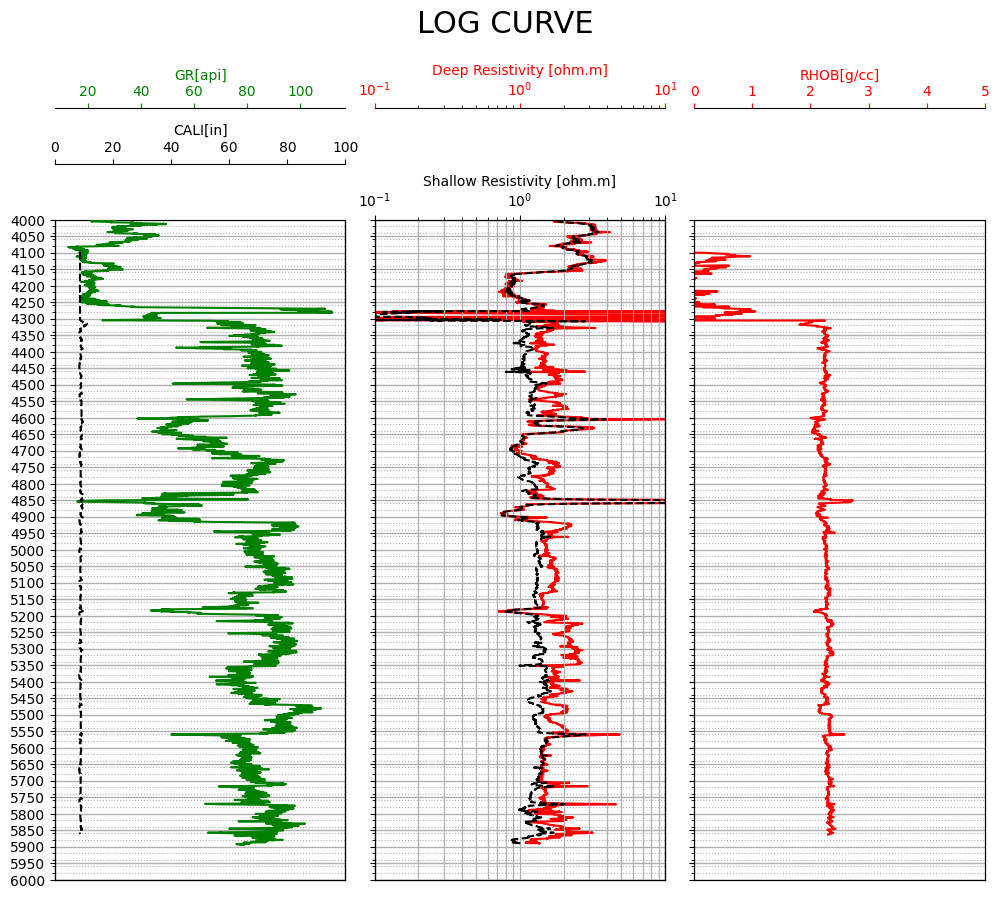

In [99]:
from src.data_vis.comboPlot import combo_plot

#Uncomment the selected_data.DEPT.min()/max() to plot for full depths
depth_start = 4000 #selected_data.DEPT.min()
depth_end = 6000 #selected_data.DEPT.max()

# DISPLAYS LOG DATA FROM THE END TO THE BOTTOM (MENTAHAN)
SP_min = "auto" #lowersp limit sp
SP_max = "auto" #sp upper limit
CALI_min = 0 #CALI lower limit
CALI_max = 100 #CALI upper limit
GR_min = "auto" #lower limit GR
GR_max = "auto" #upper limit of GR
DR_min = 0.1 #DR lower limit
DR_max = 10 #DR upper limit
MR_min = 0.1 #MR lower bound
MR_max = 10 #MR upper limit
SR_min = 0.1 #lower SR limit
SR_max = 10 #SR upper limit
RHOB_min = 0 #lower limit of RHOB
RHOB_max = 5 #upper limit of RHOB
NPHI_min = 0 #NPHI lower limit
NPHI_max = 1 #NPHI upper limit
DT_min = "auto" #lowerlimit DT
DT_max = "auto" #upper limit of DT
smoothing_traject1 = "no" #default "no"
smoothing_traject2 = "no" #default "no"
smoothing_traject3 = "no" #default "no"

combo_plot(
    selected_data,
    depth_start, 
    depth_end,
    10,               #figure height in inch
    0.77,              #figure position
    SP_min,
    SP_max,
    CALI_min,
    CALI_max,
    GR_min,
    GR_max,
    DR_min,
    DR_max,
    MR_min,
    MR_max,
    SR_min,
    SR_max,
    RHOB_min,
    RHOB_max,
    NPHI_min,
    NPHI_max,
    DT_min,
    DT_max,
    smoothing_traject1,
    smoothing_traject2,
    smoothing_traject3,
    100,
    20
    )

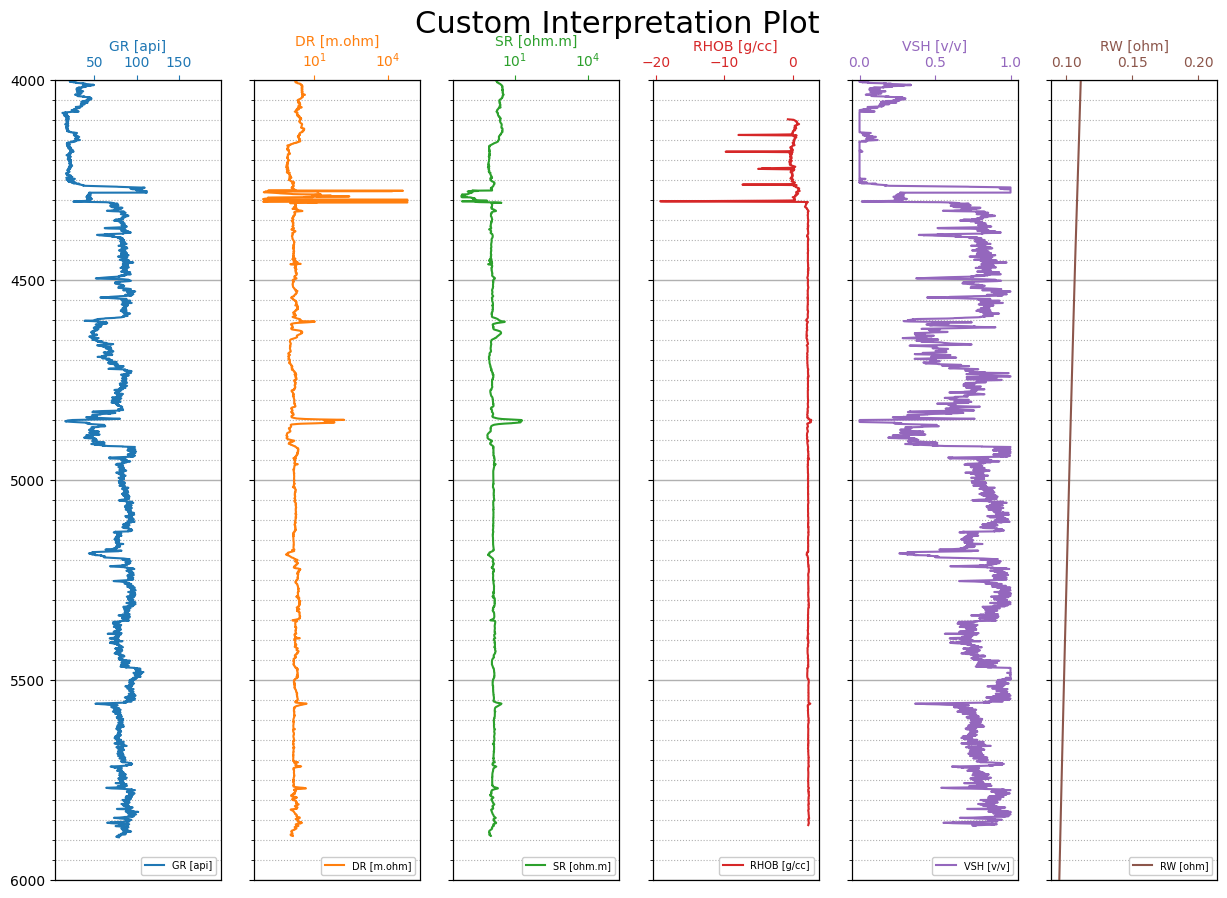

In [100]:
from src.data_vis.comboPlot import custom_plot

figure_height = 10

custom_plot(selected_data, figure_height, depth_start, depth_end, "GR", "DR", "SR", "RHOB",  "VSH", "RW", units=["api", "m.ohm", "ohm.m", "g/cc","v/v", "ohm",])

## **6. CLAY VOLUME CALCULATION**

## **Define Logs Variable for Calculations**

In [153]:
logs=selected_data[(selected_data.DEPT >= depth_start) & (selected_data.DEPT <= depth_end)]

In [154]:
logs

,WELL,DEPT,GR,CALI,DR,SR,RHOB,VSH,RW,core_por,core_perm
16000,LL-4,4000.00,30.07,NaN,2.137,1.772,NaN,0.0791,0.111175,,
16001,LL-4,4000.25,29.33,NaN,2.029,1.763,NaN,0.0690,0.111173,,
16002,LL-4,4000.50,28.26,NaN,1.985,1.750,NaN,0.0545,0.111170,,
16003,LL-4,4000.75,28.02,NaN,1.848,1.719,NaN,0.0512,0.111168,,
16004,LL-4,4001.00,30.00,NaN,1.783,1.665,NaN,0.0781,0.111166,,
...,...,...,...,...,...,...,...,...,...,...,...
23996,LL-4,5999.00,NaN,NaN,NaN,NaN,NaN,NaN,0.094957,,
23997,LL-4,5999.25,NaN,NaN,NaN,NaN,NaN,NaN,0.094955,,
23998,LL-4,5999.50,NaN,NaN,NaN,NaN,NaN,NaN,0.094954,,
23999,LL-4,5999.75,NaN,NaN,NaN,NaN,NaN,NaN,0.094952,,


#### **Define the Clean and Clay Paramater**
- Minimum (clean) and maximum (clay) values of GR for both
- Minimum (clean) and maximum (clay) values of SP for both
- Minimum (clean) and maximum (clay) values of RT for both

To start with, simply guess any numbers. Then, refer to the crossplot results in nphi vs rhob plot

In [155]:
# Clean point 1 (typical for a dense, clean rock like limestone)
neut_clean1 = 0.1  # NPHI of 0.1 (low porosity)
den_clean1 = 2.45  # RHOB of 2.45 g/cc (dense rock)

# Clean point 2 (moderate porosity, consolidated formation)
neut_clean2 = 0.25  # NPHI of 0.25 (moderate porosity)
den_clean2 = 2.0   # RHOB of 2.0 g/cc (consolidated, possibly sandstone)

# Clay point (high density, low porosity)
neut_clay = 0.05   # NPHI of 0.05 (low porosity, more clay)
den_clay = 2.65    # RHOB of 2.65 g/cc (typical for clay-rich formations)


gr_clean, gr_clay = logs.GR.min(), logs.GR.max()
rt_clean, rt_clay = logs.DR.max(), logs.DR.min()
if "SP" in logs.columns and logs["GR"].corr(logs["SP"]) > 0:
    sp_clean, sp_clay = logs.SP.min(), logs.SP.max() #In the case of being parallel to the GR, then (the smallest SP, the largest SP)
elif "SP" in logs.columns and logs["GR"].corr(logs["SP"]) < 0:
    sp_clean, sp_clay = logs.SP.max(), logs.SP.min() #If not parallel to the Gamma Ray, then (maximum SP, minimum SP).

In [156]:
from src.data_calc.vclCalc import vclrt, vclgr, vclnd, vclsp

# Alternatif (jangan dulu dipakai)
logs['VCLGR'] = vclgr(logs.GR, gr_clean, gr_clay, correction="older")
logs['VCLRT'] = vclrt(logs.DR, rt_clean, rt_clay)
# TIDAK ADA DATA NPHI
# logs['VCLND'] = vclnd(logs.NPHI, logs.RHOB, neut_clean1, den_clean1, neut_clean2, den_clean2, neut_clay, den_clay)

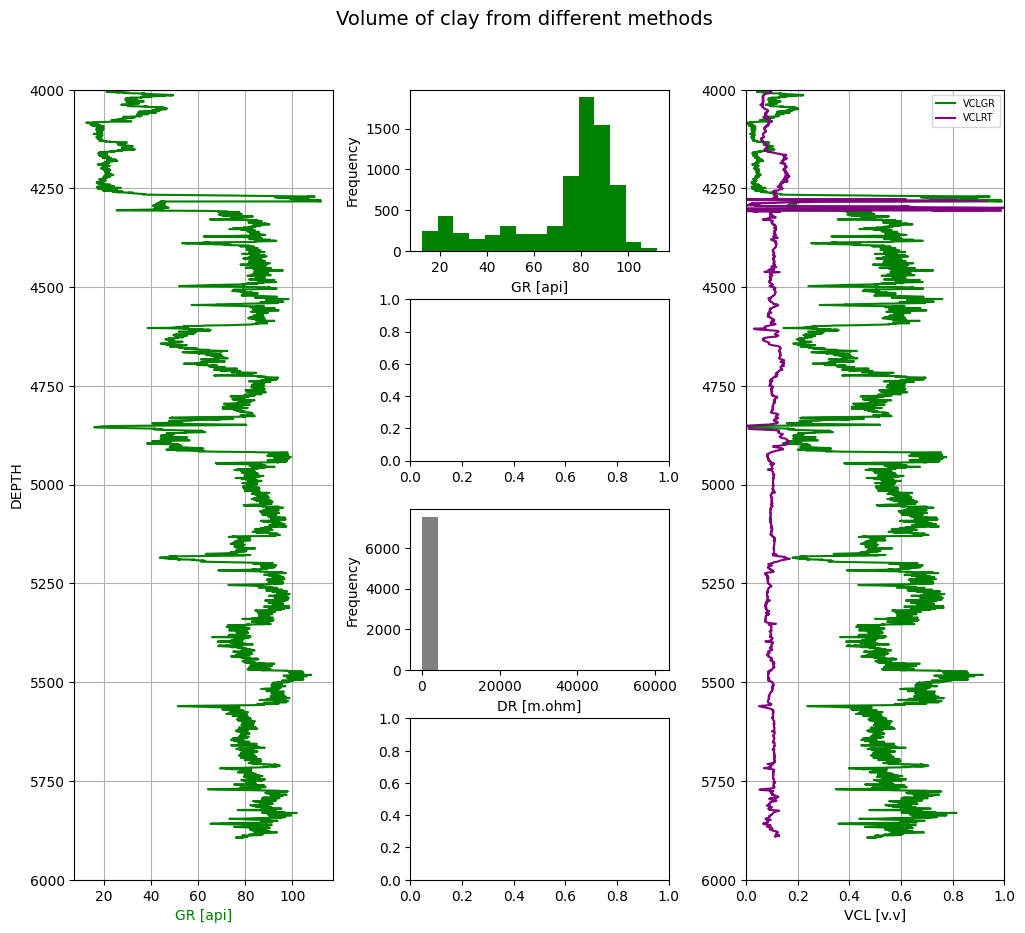

In [157]:
from src.data_vis.vclPlot import vcl_plot

vcl_plot(
    logs, 
    depth_start, 
    depth_end,
    gr_clean,
    gr_clay,
    neut_clean1,
    den_clean1,
    neut_clean2,
    den_clean2,
    neut_clay,
    den_clay,
    rhob_axis=[2.8, 1.5],
    nphi_axis=[1,0]
    )

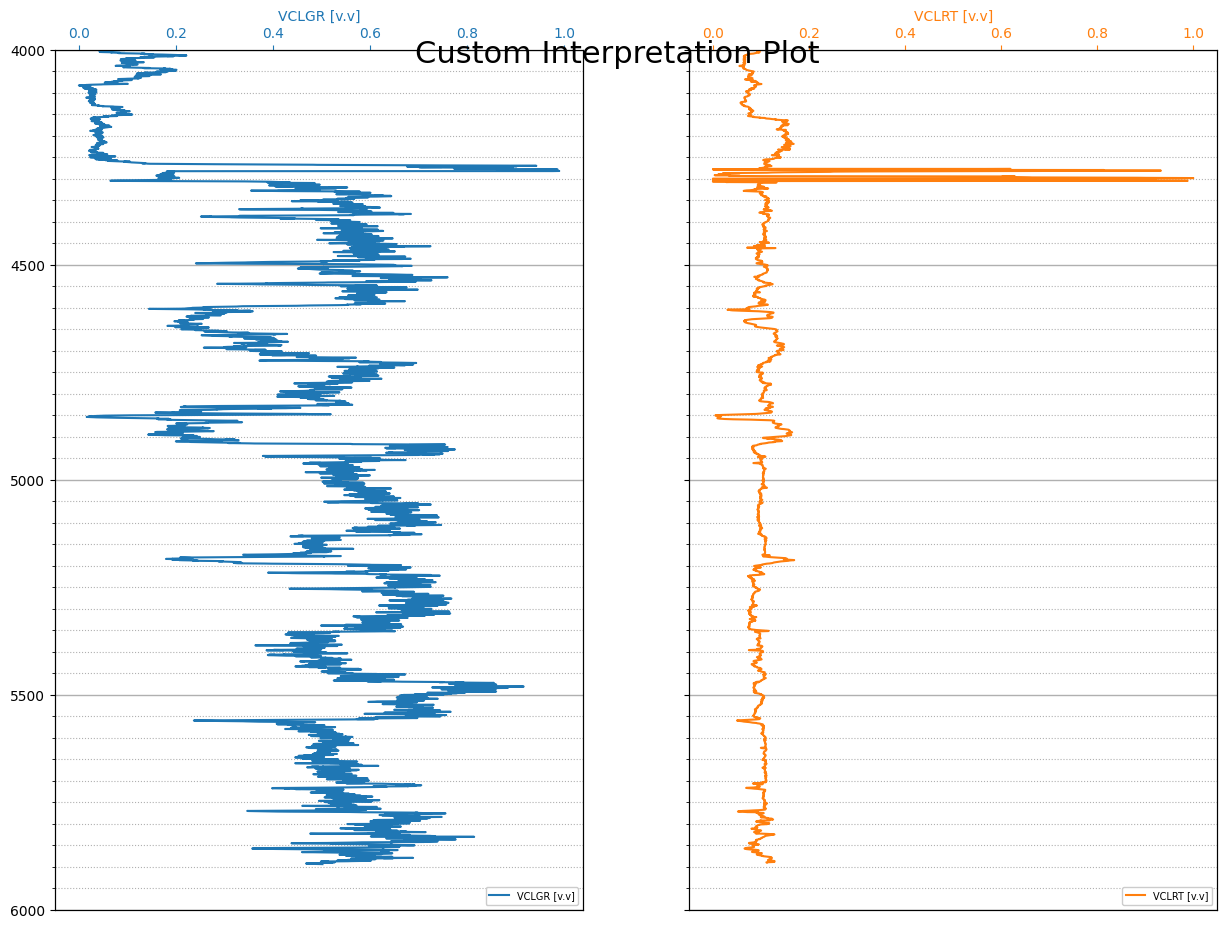

In [158]:
custom_plot(logs, figure_height, depth_start, depth_end, "VCLGR", "VCLRT", units=["v.v","v.v"])

In [159]:
logs['VCL']=logs['VCLRT']

## **7. POROSITY CALCULATION**
There are three types of logs that can be used to estimate porosity: sonic, density, and neutron logs. Porosity can be determined using either individual or paired combinations of these logs. The possible combinations include neutron-density, neutron-sonic, and sonic-density.<br>
**Basic porosity formulas are:**
- Sonic:
    - Wyllie (Time Average)
    - Raymer-Hunt-Gardner
- Density
- Neutronic<br>

## **Define the Parameter for Porosity Calculations**

In [160]:
from src.data_calc.poroCalc import phis_shale

#Matrix, fluid and appropiate shales values must be declared in the next variables:
dt_ma, dt_fl, dt_sh, cp, alpha = 55.5, 188.0, 90.0, 1, 5/8
den_ma = 2.24
den_fl = 0.1
den_sh = den_clay

phis_sh=phis_shale(dt_sh, dt_ma, dt_fl)
phid_sh=phis_shale(den_sh, den_ma, den_fl)
phin_sh=45

In [161]:
from src.data_calc.poroCalc import ( phis_w, phis_w_sh_corr, phis_rhg, phis_rhg_sh_corr,
                                phid, phid_sh_corr, phi_simandoux, phin_sh_corr, phixnd)

# # 1. Poro calc with DT 
# TIDAK ADA DATA DT
# logs['PHISw']=phis_w(logs.DT, dt_ma, dt_fl, cp)
# logs['PHISwshc']=phis_w_sh_corr(logs.DT, dt_ma, dt_fl, cp, dt_sh, logs.VCL).clip(0,1)

# logs['PHISrhg']=phis_rhg(logs.DT, dt_ma, alpha)
# logs['PHISrhgshc']=phis_rhg_sh_corr(logs.DT, dt_ma, dt_sh, logs.VCL,alpha,dt_fl).clip(0,1)

# # 2. Poro calc with RHOB
logs['PHID']=phid(logs.RHOB, den_ma, den_fl, new=True)
logs['PHIDshc']=phid_sh_corr(logs.RHOB, den_ma, den_fl, den_sh, logs.VCL).clip(0,1)

# # 3. Poro calc for Simandoux using VSH param
logs['PHI_SIMANDOUX']=phi_simandoux(logs.VSH,logs.PHID).clip(0,1)

# # 4. Poro calc with NPHIN (Dual-method)
# TIDAK ADA DATA NPHI
# logs['PHIN']=(logs.NPHI/100).clip(0,1)
# logs['PHINshc']=phin_sh_corr(logs.NPHI, phin_sh, logs.VCL).clip(0,1)

# logs['PHIxND']=phixnd(logs.PHINshc,logs.PHIDshc).clip(0,1)

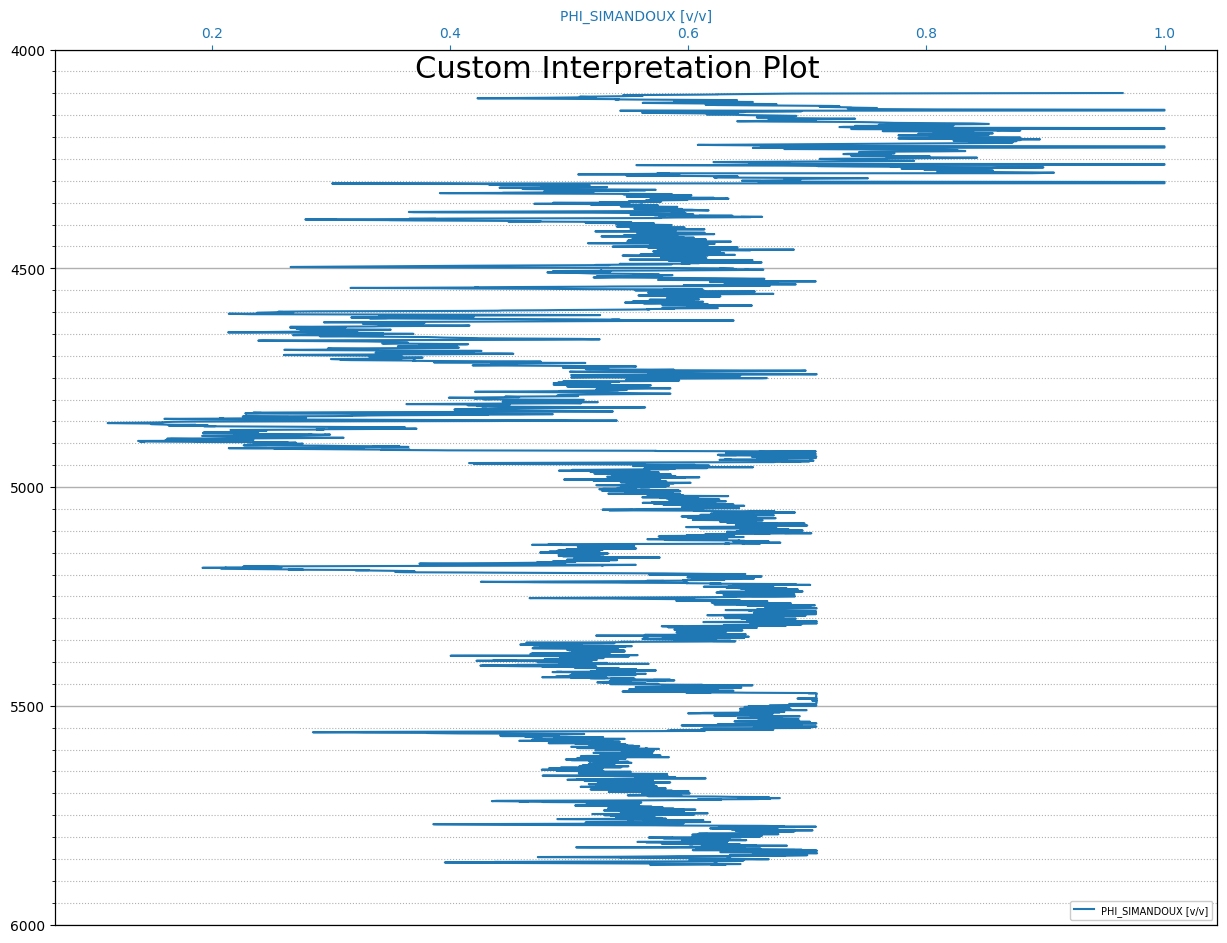

In [162]:
# Example usage:
custom_plot(logs, figure_height, depth_start, depth_end,  "PHI_SIMANDOUX", units=["v/v"])

In [163]:
logs['PHIE'] = logs['PHID']

## **8. WATER SATURATION CALCULATION**
Before calculating the water saturation will need a value for the Rw (Resistivity of water)<br>
**Resistivity of water:**
It can be determined from:
- Ater catalogs <br>
- DST test water analysis <br>
- Rw from SP (needs information about Rmud and ... ) <br>
- Rwa Method (Rw from a 100% water zone) <br>

### **8.1. Archie Water Sturation Equation**
Suppose we lack any prior knowledge of Rwater. In such cases, following the best approach involves utilizing a PICKETT graph. This graph takes on a logarithmic form derived from Archie's equation:

$Sw^{n} = \frac{a \times R_w}{R_t \times \phi^m}$

## **Define the Parameters**
Firstly, it's important to establish the values for the variables: a, m, and n. To initiate this process, you might consider beginning with the values (a=1, m=2, n=2), which tend to yield favorable results across various rock types. In cases where the rock matrix contains a mixture of shale, it might be advisable to reduce the value of m to 1.8.
- a, turtuosity factor
- m, cementation factor
- n, saturation exponent
- rwa, water resistivity
- vcl_limit, volume of clay upper limit for selction of data for graph

In [164]:
a = 0.9
m = 1
n = 1.8
rt = 0.8

#### **8.1.2. Choose the Water Resistivity**

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


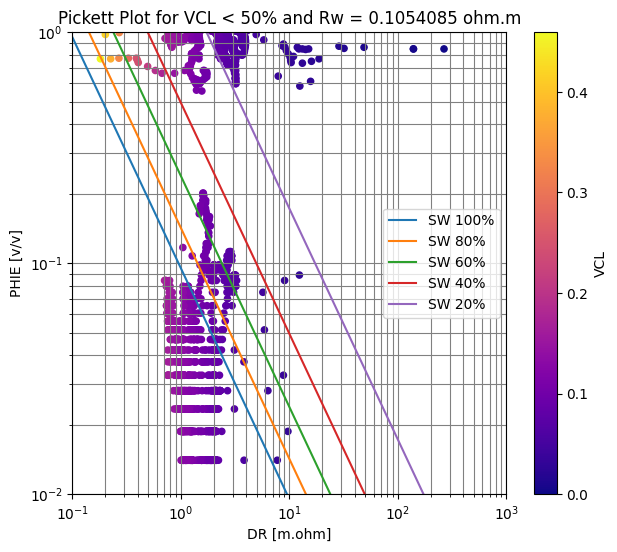

In [204]:
from src.data_vis.interpretPlot import pickett_plot
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from src.data_vis.interpretPlot import pickett_plot
%reload_ext autoreload
rwa_input = logs['RW'].median()

pickett_plot(logs, depth_start=0, depth_end=10000, vcl_limit = 0.5, a = a, rwa = rwa_input, m = m, n = n, z = "VCL")

In [205]:
Rw = 0.12 # Water resistivity adjusted based on picket plot

The outcomes obtained from the Pickett plot indicate the presence of distinct intervals within two zones, warranting separate interpretation and analysis. To initiate the process, we will select an appropriate value for Rwa and utilize the Archie equation to compute the Sw curve.

Next, proceed to select the water resistivity, denoted as rwa. We will create a Pickett chart by plotting Resistivity against Porosity. To curate the data for this plot, focus exclusively on the reservoir formations while excluding the shaly intervals. This can be accomplished by adjusting the vcl_limit variable, which represents the volume of clay.

#### **8.2.1. Define the Thermal Gradient for Waxman-Smits Water Saturation Calculation**

In [206]:
#Geothermal Gradient
mid_perf = 13950  #TVD
BHT_mid_perf = 192 #Fahrenheit
T_surf = 60 #Fahrenheit
T_gradient = (BHT_mid_perf-T_surf)/(mid_perf) #Fahrenheit/ft

# Create new column 'CEC' and 'T' for SWwaxman Calc
logs["CEC"] = -47.619 * logs["VCL"] ** 2.0 + 61.429 * logs["VCL"]
logs["T"] = T_surf + T_gradient * logs["DEPT"]

#### **8.1.3. Calculation of the Water Saturation**
and call it in order to have the result of saturation Swa. Clip the results between (0,1).

In [207]:
from src.data_calc.swCalc import sw_indonesia, sw_archie, sw_simandoux, sw_waxman

logs['SWarchie'] = logs.apply(lambda row: sw_archie(Rw, rt, row['PHIE'], a, m, n), axis = 1)

logs["SWsimandoux"] = sw_simandoux(Rw, rt, logs.VSH, logs.PHI_SIMANDOUX, a, m, n, logs.DR).clip(0, 1)

logs['SWwaxman'] = logs.apply(
    lambda row: sw_waxman(Rw, row['CEC'], a, m, n, row['T'], row['DR'], row['PHIE']), axis=1
)

logs["SWindonesia"] = logs.apply(
    lambda row: sw_indonesia(Rw, row['DR'], row['PHIE'], a, m, n, row['VCL'], rsh=100), axis=1
)

## **Bulk volume water Calc**

In [208]:
"""
Calculate bulk volume water (BVW) and matrix fraction for well log data.

Parameters:
-----------
logs : pandas DataFrame
    Well log data containing porosity, water saturation, and clay volume curves.
SWarchie : pandas Series
    Water saturation calculated using Archie's equation.
PHIE : pandas Series
    Effective porosity.
VCL : pandas Series
    Volume of clay fraction.

Returns:
--------
BVW : pandas Series
    Bulk volume water, calculated as the product of water saturation and effective porosity.
matrix : pandas Series
    Matrix fraction, calculated as the remaining volume after subtracting clay volume and effective porosity from 1.
"""
logs['BVW'] = logs['SWarchie'] * logs['PHIE']
logs['matrix'] = 1 - logs['VCL'] - logs['PHIE']

## **Choose best SW**

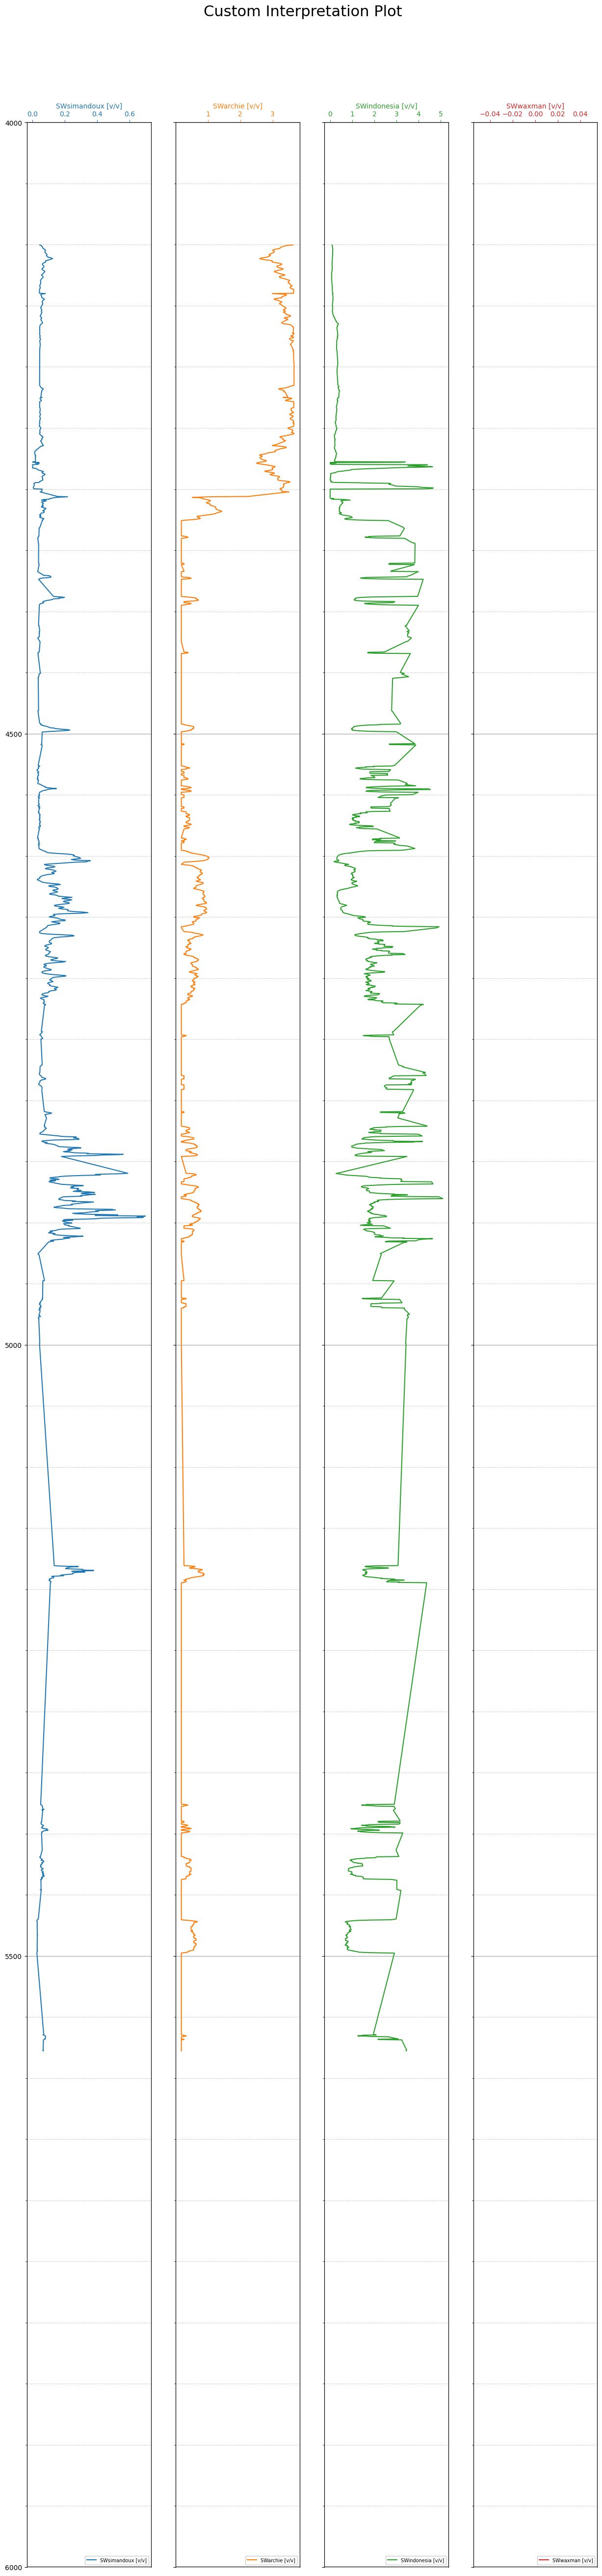

In [ ]:
custom_plot(logs, 30, depth_start, depth_end, "SWsimandoux", "SWarchie", "SWindonesia", "SWwaxman", units=["v/v", "v/v", "v/v", "v/v"])

In [210]:
from src.data_calc.permCalc import perm_timur

logs['PERMtimur'] = logs.apply(lambda row: perm_timur(row['PHIE'],row['SWarchie']), axis=1)

In [211]:
#drop logs["perm"] above 1000
logs = logs[logs["PERMtimur"] < 1000]

## **Interpretation Plot**

In [212]:
data.columns
if("MR" in data.columns and (MR_min!=0 or MR_max!=0)):
    print("blin")

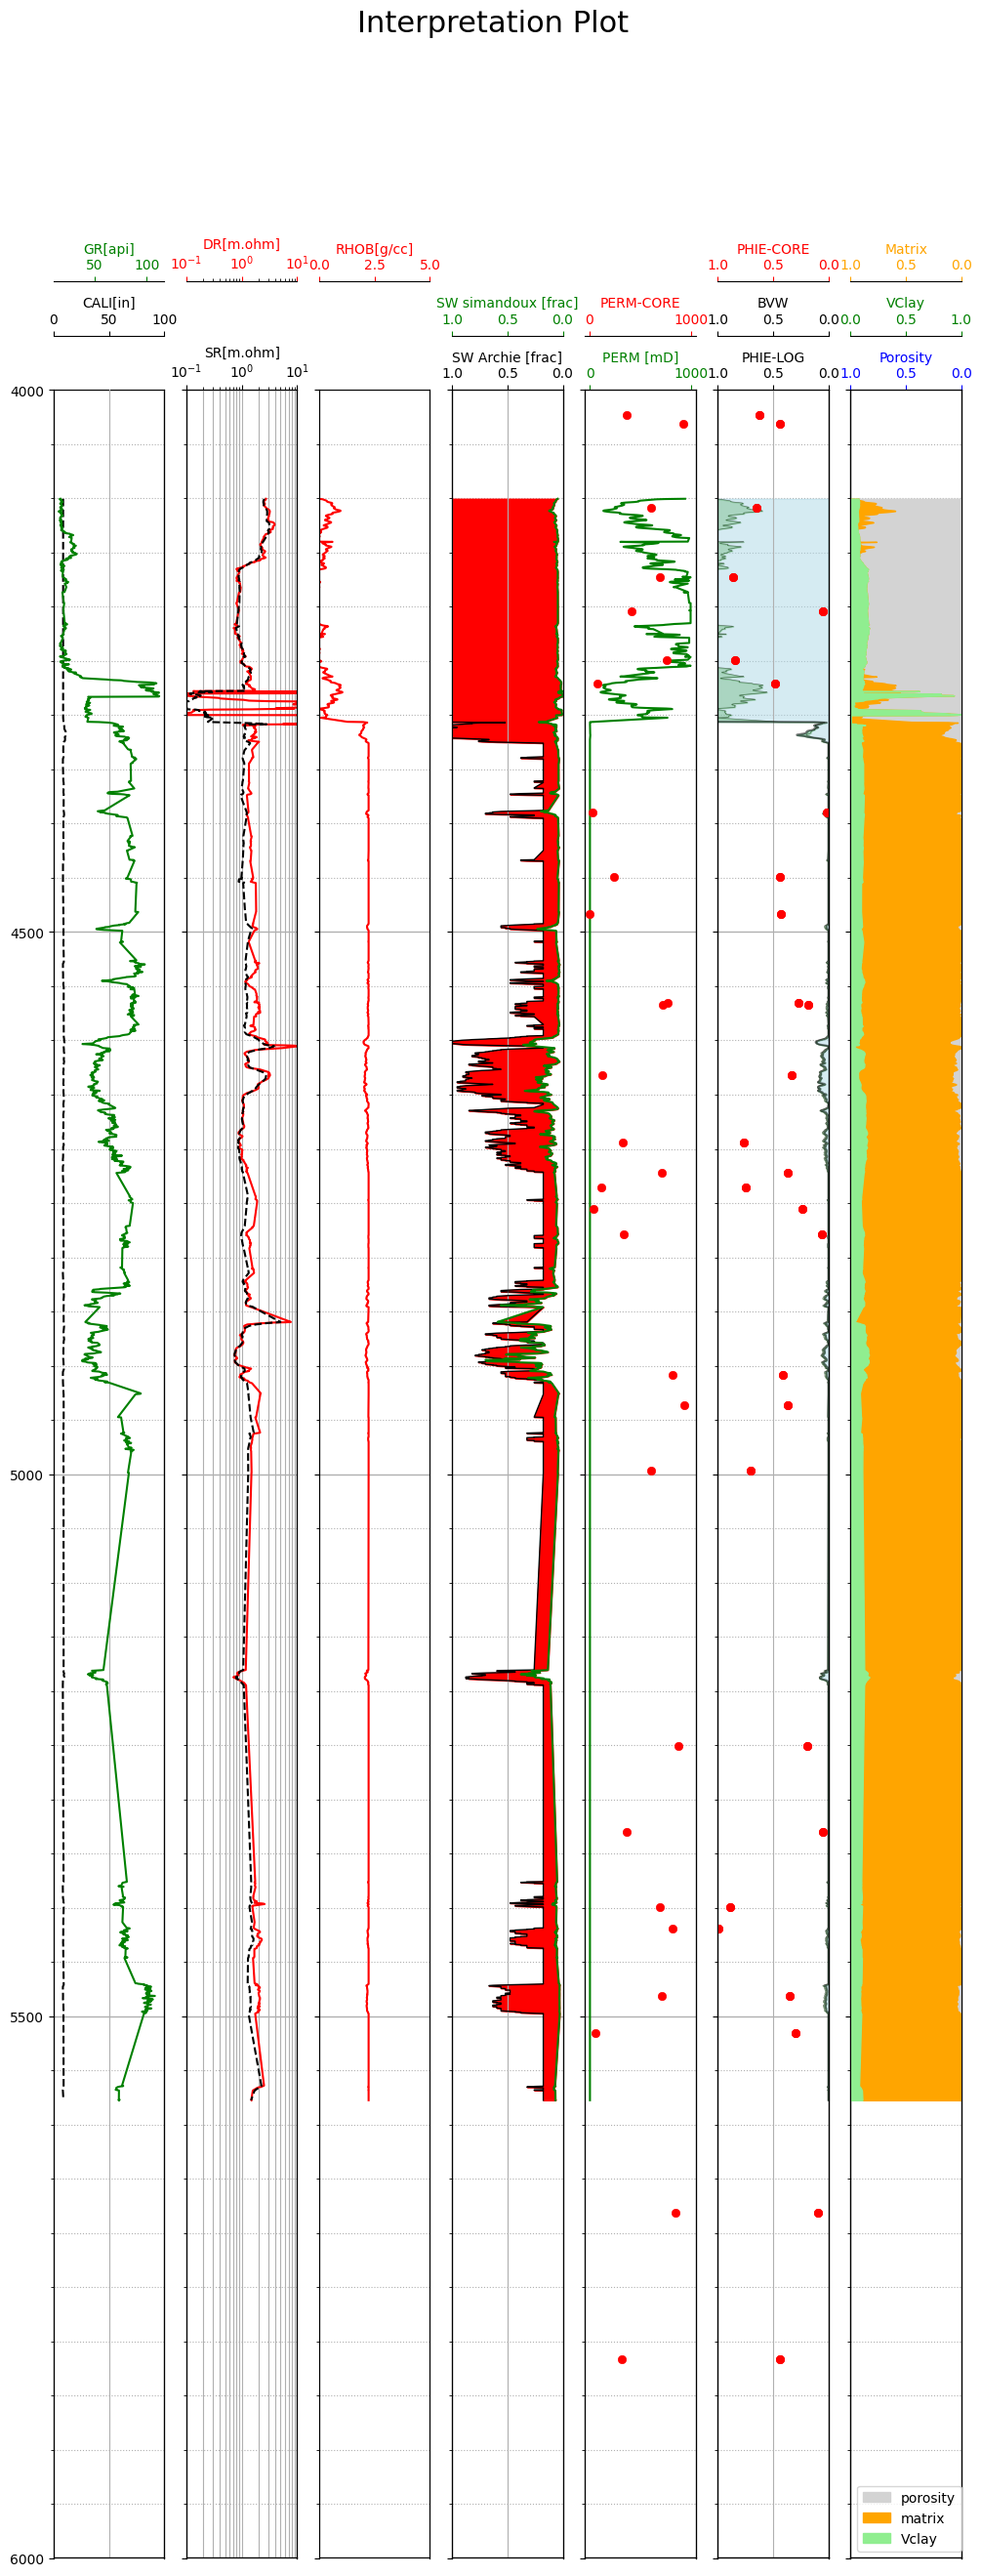

In [213]:
from src.data_vis.interpretPlot import interpretation_plot

NPHI_max = 100
NPHI_min = 0
interpretation_plot(
    logs,
    core_selected_data,
    30,
    depth_start,
    depth_end,
    SP_min,
    SP_max,
    CALI_min,
    CALI_max,
    GR_min,
    GR_max,
    DR_min,
    DR_max,
    MR_min,
    MR_max,
    SR_min,
    SR_max,
    RHOB_min,
    RHOB_max,
    NPHI_min,
    NPHI_max,
    DT_min,
    DT_max,
    "PERMtimur",
    "yes"
    )

In [214]:
top_clean = 3865
bottom_clean = 3885
mean_waxman = logs[(logs['DEPT'] >= top_clean) & (logs['DEPT'] <= bottom_clean)]["SWwaxman"].mean()
mean_archie = logs[(logs['DEPT'] >= top_clean) & (logs['DEPT'] <= bottom_clean)]["SWarchie"].mean()
SW_coef = mean_archie/mean_waxman

In [215]:
logs["SWwaxman_corrected"] = logs["SWwaxman"] * SW_coef

## **Save the all of the output to xlsx files**

In [216]:
# Specify the file path where you want to save the Excel file
file_path = "../results/output1.xlsx"

# Export the DataFrame to an Excel file
logs.to_excel(file_path, index=False)  # Set index=False to exclude the index column

print(f"DataFrame has been exported to {file_path}")


DataFrame has been exported to ../results/output1.xlsx


## **Other crossplot**

In [217]:
from src.data_vis.distPlot import crossplot

# NO NPHI Data
# crossplot(logs,'NPHI','RHOB',"GR","frac","g/cc","API")